# Glitching instructions

Here we are going to try to analyze the possible results from glitching under the point of view of the instructions involved

## Preparation

Start with the parameters and the building of our firmware

In [1]:
from hexdump import hexdump
from IPython import display
import pandas as pd
import struct

In [2]:
SCOPETYPE = 'OPENADC'
PLATFORM = 'CWLITEXMEGA'
# sample_size = 5

In [3]:
from pathlib import Path

PATH_CW = Path('/opt/ChipWhisperer-git/')
PATH_FW = PATH_CW / "hardware/victims/firmware/simpleserial-experiments/simpleserial-experiments-{}.hex".format(PLATFORM)

import chipwhisperer as cw
try:
    if not scope.connectStatus:
        scope.con()
except NameError:
    scope = cw.scope()
   
try:
    target = cw.target(scope)
except IOError:
    print("INFO: Caught exception on reconnecting to target - attempting to reconnect to scope first.")
    print("INFO: This is a work-around when USB has died without Python knowing. Ignore errors above this line.")
    scope = cw.scope()
    target = cw.target(scope)

print("INFO: Found ChipWhisperer😍")

Serial baud rate = 38400
INFO: Found ChipWhisperer😍


In [4]:
%%bash -s "$PLATFORM" "$PATH_FW.parent"
cd ${2}
echo ${2}
make PLATFORM=$1 | tail

/opt/ChipWhisperer-git/hardware/victims/firmware/simpleserial-experiments
   6524	     16	     52	   6592	   19c0	simpleserial-experiments-CWLITEXMEGA.elf
+--------------------------------------------------------
+ Default target does full rebuild each time.
+ Specify buildtarget == allquick == to avoid full rebuild
+--------------------------------------------------------
+--------------------------------------------------------
+ Built for platform CW-Lite XMEGA with:
+ CRYPTO_TARGET = AVRCRYPTOLIB
+ CRYPTO_OPTIONS = DES
+--------------------------------------------------------


In [5]:
prog = cw.programmers.XMEGAProgrammer

import time
time.sleep(0.05)
scope.default_setup()
def reset_target(scope):
    scope.io.pdic = 'low'
    time.sleep(0.1)
    scope.io.pdic = 'high_z' #XMEGA doesn't like pdic driven high
    time.sleep(0.1) #xmega needs more startup time

cw.program_target(scope, prog, str(PATH_FW))

XMEGA Programming flash...
XMEGA Reading flash...
Verified flash OK, 6539 bytes


In [6]:
target.flush()
reset_target(scope)
data = target.read()
print(repr(data))

'\x00helloè\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\x0c\r\x0e\x0f\x10\x11\x12\x13\x14\x15\x16\x17\x18\x19\x1a\x1b\x1c\x1d\x1e\x1f'


## Glitching

Now we have our target programmed we can start to attack it with our glitching attempts.



In [7]:
REGISTERS_DEFAULT = {
    'r0': 232,
    'r1': 0x01,
    'r2': 0x02,
    'r3': 0x03,
    'r4': 0x04,
    'r5': 0x05,
    'r6': 0x06,
    'r7': 0x07,
    'r8': 0x08,
    'r9': 0x09,
    'r10': 0x0a,
    'r11': 0x0b,
    'r12': 0x0c,
    'r13': 0x0d,
    'r14': 0x0e,
    'r15': 0x0f,
    'r16': 0x10,
    'r17': 0x11,
    'r18': 0x12,
    'r19': 0x13,
    'r20': 0x14,
    'r21': 0x15,
    'r22': 0x16,
    'r23': 0x17,
    'r24': 0x18,
    'r25': 0x19,
    'r26': 0x1a,
    'r27': 0x1b,
    'r28': 0x1c,
    'r29': 0x1d,
    'r30': 0x1e,
    'r31': 0x1f,
}

print(REGISTERS_DEFAULT)

{'r0': 232, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}


In [13]:
import chipwhisperer.common.results.glitch as glitch
from enum import Enum

class Experiment:
    class Result(Enum):
        NORMAL = 1
        RESET = 2
        GLITCH = 3

    """Class to wrap scope, target and glitch parameters"""
    def __init__(self, _scope, _target, global_step=5, **params):
        self.scope = _scope
        self.target = _target
        self.global_step = global_step
        self.params = params
        self.gc = None
        self.results = []
        
        self._setup_glitch_controller()
        
    def _setup_glitch_controller(self):
        self.scope.default_setup()
        self.scope.glitch.clk_src = 'clkgen'
        self.scope.glitch.trigger_src = 'ext_single'
        self.scope.glitch.repeat = 1
        self.scope.glitch.output = 'clock_xor'
        self.scope.io.hs2 = "glitch"

        self.gc = glitch.GlitchController(
            groups=["success", "reset", "normal"],
            parameters=[_ for _ in self.params],
        )
        
        for param_name, param_range in self.params.items():
            self.gc.set_range(param_name, *param_range)
            
        self.gc.set_global_step(self.global_step)

    def reboot_flush(self):            
        #Flush garbage too
        self.target.flush()
        self.scope.io.pdic = False
        time.sleep(0.1)
        self.scope.io.pdic = "high_z"
        time.sleep(0.1)

    def _parse(self, d, debug=False):
        valid = False
        data = d.encode('iso-8859-1')
        payload = None

        if debug:
            hexdump(d)

        if data[:6] == b'\x00hello':  # probably the device reseted itself
            try:
                values = struct.unpack('B'*32, data[6:])
                payload = {'r{}'.format(idx):_ for idx, _ in enumerate(values)}
                valid = True
            except Exception as e:
                pass
        
        return {
            'valid': valid, 
            'data': data,
            'payload': payload,
        }
    
    def capture(self, with_trace=False):
        self.reboot_flush()
        # time.sleep(2)
        trace = None
        if with_trace:
            scope.capture()

        data = self.target.read()

        trace = self.scope.get_last_trace()
    
        return trace, data.encode("iso-8859-1")  # in this way I don't get weird unicode artefacts for 0x80
        
    def glitch(self, **values):
        glitch_settings = self.scope.glitch
        
        for value_name, value in values.items():
            setattr(glitch_settings, value_name, value)

        scope.arm()
        self.reboot_flush()

        data = self.target.read()
        
        val = self._parse(data)
        
        _values = tuple(values.values())  # transform as a list
        
        if not val['valid']: #fill in with invalid response detection
            self.gc.add("reset", _values)
            self.results.append((self.Result.RESET, data, *_values))
            #plt.plot(scope.glitch.width, scope.glitch.offset, 'xr', alpha=1)
            #fig.canvas.draw()
        else:
            if val['payload'] != REGISTERS_DEFAULT: # replace this
                self.gc.add("success", _values)
                self.results.append((self.Result.GLITCH, val['payload'], *_values))
                print(val['payload'])
                print(_values)
                print("🐙", end="")
            else:
                self.gc.add("normal", _values)

    def run(self):
        print("-- Starting session")
        print(self.scope)  # obtain info about setup
        self.gc.display_stats()
        for glitch_settings in self.gc.glitch_values():
            self.glitch(**{name: value for name, value in zip(self.params, glitch_settings)})

In [14]:
experiment = Experiment(scope, target, ext_offset=[0, 100], width=[-49, 49], offset=[-49, 49])
experiment.run()

cwlite Device
fw_version = 
    major = 0
    minor = 20
    debug = 0
gain = 
    mode = high
    gain = 30
    db   = 24.8359375
adc = 
    state      = True
    basic_mode = rising_edge
    timeout    = 2
    offset     = 0
    presamples = 0
    samples    = 5000
    decimate   = 1
    trig_count = 4004530378
clock = 
    adc_src       = clkgen_x4
    adc_phase     = 0
    adc_freq      = 29538459
    adc_rate      = 29538459.0
    adc_locked    = True
    freq_ctr      = 0
    freq_ctr_src  = extclk
    clkgen_src    = system
    extclk_freq   = 10000000
    clkgen_mul    = 2
    clkgen_div    = 26
    clkgen_freq   = 7384615.384615385
    clkgen_locked = True
trigger = 
    triggers = tio4
    module   = basic
io = 
    tio1       = serial_rx
    tio2       = serial_tx
    tio3       = high_z
    tio4       = high_z
    pdid       = high_z
    pdic       = high_z
    nrst       = high_z
    glitch_hp  = False
    glitch_lp  = False
    extclk_src = hs1
    hs2        = glitch
   

IntText(value=0, description='success count:', disabled=True)

IntText(value=0, description='reset count:', disabled=True)

IntText(value=0, description='normal count:', disabled=True)

FloatSlider(value=0.0, continuous_update=False, description='ext_offset setting:', disabled=True, readout_form…

FloatSlider(value=-49.0, continuous_update=False, description='width setting:', disabled=True, max=49.0, min=-…

FloatSlider(value=-49.0, continuous_update=False, description='offset setting:', disabled=True, max=49.0, min=…

{'r0': 232, 'r1': 1, 'r2': 2, 'r3': 2, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([0, -4, -44])
🐙

{'r0': 232, 'r1': 1, 'r2': 2, 'r3': 0, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([0, -4, 46])
🐙

{'r0': 232, 'r1': 1, 'r2': 2, 'r3': 2, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([0, 6, -9])
🐙{'r0': 232, 'r1': 1, 'r2': 255, 'r3': 2, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([0, 6, -4])
🐙{'r0': 232, 'r1': 1, 'r2': 2, 'r3': 2, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26

{'r0': 232, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 0, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([5, -34, 36])
🐙

{'r0': 232, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 0, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([5, -29, 31])
🐙

{'r0': 232, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 0, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([5, -4, -44])
🐙

{'r0': 232, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 5, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([5, -4, 46])
🐙

{'r0': 232, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 0, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([5, 6, -9])
🐙{'r0': 232, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 0, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([5, 6, -4])
🐙{'r0': 232, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 0, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 

{'r0': 232, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 0, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([5, 16, -14])
🐙

{'r0': 232, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 0, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([10, -49, -49])
🐙

{'r0': 232, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 7, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([10, -4, -44])
🐙

{'r0': 232, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 0, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([10, -4, 46])
🐙

{'r0': 232, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 7, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([10, 6, -9])
🐙{'r0': 232, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 7, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([10, 6, -4])
🐙{'r0': 232, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 7, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26

{'r0': 232, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 7, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([10, 31, -29])
🐙

{'r0': 232, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 7, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([10, 36, -34])
🐙

{'r0': 232, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 10, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([15, -44, 46])
🐙{'r0': 232, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 0, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([15, -39, 41])
🐙

{'r0': 232, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 0, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([15, -29, 31])
🐙

{'r0': 232, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 0, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([15, -4, -44])
🐙

{'r0': 232, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 10, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([15, -4, 46])
🐙

{'r0': 232, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 0, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([15, 6, -9])
🐙{'r0': 232, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 0, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([15, 6, -4])
🐙{'r0': 232, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 0, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, '

{'r0': 232, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 10, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([15, 46, -49])
🐙

{'r0': 232, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 12, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([20, -34, 36])
🐙

{'r0': 232, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 0, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([20, -9, 11])
🐙

{'r0': 232, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 12, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([20, -4, -44])
🐙

{'r0': 232, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 0, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([20, -4, 46])
🐙

{'r0': 232, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 12, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([20, 6, -9])
🐙{'r0': 232, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 253, 'r13': 12, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([20, 6, -4])
🐙{'r0': 232, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 12, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 2

{'r0': 232, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 12, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([20, 41, -39])
🐙

{'r0': 232, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 15, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([25, -4, -49])
🐙{'r0': 232, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 0, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([25, -4, -44])
🐙

{'r0': 232, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 15, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([25, -4, 46])
🐙

{'r0': 232, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 0, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([25, 6, -9])
🐙{'r0': 232, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 0, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([25, 6, -4])
🐙{'r0': 232, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 0, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, '

{'r0': 232, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 17, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([30, -4, -44])
🐙

{'r0': 232, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 32, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([30, -4, 46])
🐙

{'r0': 232, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 17, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([30, 6, -9])
🐙{'r0': 232, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 17, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([30, 6, -4])
🐙{'r0': 232, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 17, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26

{'r0': 232, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 32, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([30, 31, -29])
🐙

{'r0': 232, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 0, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([35, -34, 36])
🐙

{'r0': 232, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 0, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([35, -19, 21])
🐙

{'r0': 232, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 0, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([35, -4, -44])
🐙

{'r0': 232, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 20, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([35, -4, 46])
🐙

{'r0': 232, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 0, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([35, 6, -9])
🐙{'r0': 232, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 0, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([35, 6, -4])
🐙{'r0': 232, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 0, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, '

{'r0': 232, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 0, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([35, 16, -14])
🐙

{'r0': 232, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 20, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([35, 41, -39])
🐙

{'r0': 232, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 22, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([40, -4, -44])
🐙

{'r0': 232, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 0, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([40, -4, 46])
🐙

{'r0': 232, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 22, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([40, 6, -9])
🐙{'r0': 232, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 22, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([40, 6, -4])
🐙{'r0': 232, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 22, 'r24': 24, 'r25': 25, 'r26': 26

{'r0': 232, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 32, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([45, -34, 36])
🐙

{'r0': 232, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 32, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([45, -29, 31])
🐙

{'r0': 232, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 32, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([45, -4, -44])
🐙

{'r0': 232, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 25, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([45, -4, 46])
🐙

{'r0': 232, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 32, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([45, 6, -9])
🐙{'r0': 232, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 32, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([45, 6, 1])
🐙

{'r0': 232, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 1, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([50, -39, 41])
🐙

{'r0': 232, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 27, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([50, -4, -44])
🐙

{'r0': 232, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 1, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([50, -4, 46])
🐙

{'r0': 232, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 27, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([50, 6, -9])
🐙{'r0': 232, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 26, 'r28': 27, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([50, 6, -4])
🐙{'r0': 232, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26

{'r0': 232, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 1, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([50, 46, -49])
🐙

{'r0': 232, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 160, 'r31': 31}
dict_values([55, -49, -49])
🐙

{'r0': 232, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 160, 'r31': 31}
dict_values([55, -29, 31])
🐙

{'r0': 232, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 160, 'r31': 31}
dict_values([55, -4, -44])
🐙

{'r0': 232, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 30}
dict_values([55, -4, 46])
🐙

{'r0': 232, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 160, 'r31': 31}
dict_values([55, 6, -9])
🐙{'r0': 232, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 30}
dict_values([55, 6, -4])
🐙{'r0': 232, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 2

{'r0': 232, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 30}
dict_values([55, 46, -44])
🐙

{'r0': 231, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([60, -4, -44])
🐙

{'r0': 231, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([60, -4, 46])
🐙

{'r0': 231, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([60, 6, -9])
🐙{'r0': 231, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([60, 6, -4])
🐙{'r0': 231, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26

{'r0': 231, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([60, 36, -34])
🐙

{'r0': 231, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([60, 46, -44])
🐙

{'r0': 231, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([65, -4, -44])
🐙

{'r0': 231, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([65, -4, 46])
🐙

{'r0': 231, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([65, 6, -9])
🐙{'r0': 231, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([65, 6, -4])
🐙{'r0': 231, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26

{'r0': 231, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([65, 21, -19])
🐙

{'r0': 231, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([65, 36, -34])
🐙

{'r0': 231, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([70, -29, 31])
🐙

{'r0': 231, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([70, -4, -49])
🐙{'r0': 231, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([70, -4, -44])
🐙

{'r0': 231, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([70, -4, 46])
🐙

{'r0': 231, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([70, 6, -9])
🐙{'r0': 231, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([70, 6, -4])
🐙{'r0': 231, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26

{'r0': 231, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([70, 46, -44])
🐙

{'r0': 231, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([75, -29, 31])
🐙

{'r0': 231, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([75, -4, -44])
🐙

{'r0': 231, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([75, -4, 46])
🐙

{'r0': 231, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([75, 6, -9])
🐙{'r0': 231, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([75, 6, 1])
🐙

{'r0': 231, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([75, 16, -14])
🐙

{'r0': 231, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([75, 21, -19])
🐙

{'r0': 231, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([80, -4, -44])
🐙

{'r0': 231, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([80, -4, 46])
🐙

{'r0': 231, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([80, 6, -9])
🐙{'r0': 231, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([80, 6, -4])
🐙{'r0': 231, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26

{'r0': 231, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([85, -4, -44])
🐙

{'r0': 231, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([85, -4, 46])
🐙

{'r0': 231, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([85, 6, -9])
🐙{'r0': 231, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([85, 6, -4])
🐙{'r0': 231, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26

{'r0': 231, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([90, -4, -44])
🐙

{'r0': 231, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([90, -4, 46])
🐙

{'r0': 231, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([90, 6, -9])
🐙{'r0': 231, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([90, 6, 1])
🐙

{'r0': 231, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([90, 21, -19])
🐙

{'r0': 231, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([95, -4, -44])
🐙

{'r0': 231, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([95, -4, 46])
🐙

{'r0': 231, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([95, 6, -9])
🐙{'r0': 231, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([95, 6, -4])
🐙{'r0': 231, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26

{'r0': 231, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([95, 21, -19])
🐙

{'r0': 231, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([100, -4, -44])
🐙

{'r0': 231, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([100, -4, 46])
🐙

{'r0': 231, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([100, 6, -9])
🐙{'r0': 231, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 26, 'r27': 27, 'r28': 28, 'r29': 29, 'r30': 30, 'r31': 31}
dict_values([100, 6, -4])
🐙{'r0': 231, 'r1': 1, 'r2': 2, 'r3': 3, 'r4': 4, 'r5': 5, 'r6': 6, 'r7': 7, 'r8': 8, 'r9': 9, 'r10': 10, 'r11': 11, 'r12': 12, 'r13': 13, 'r14': 14, 'r15': 15, 'r16': 16, 'r17': 17, 'r18': 18, 'r19': 19, 'r20': 20, 'r21': 21, 'r22': 22, 'r23': 23, 'r24': 24, 'r25': 25, 'r26': 

<IPython.core.display.Javascript object>


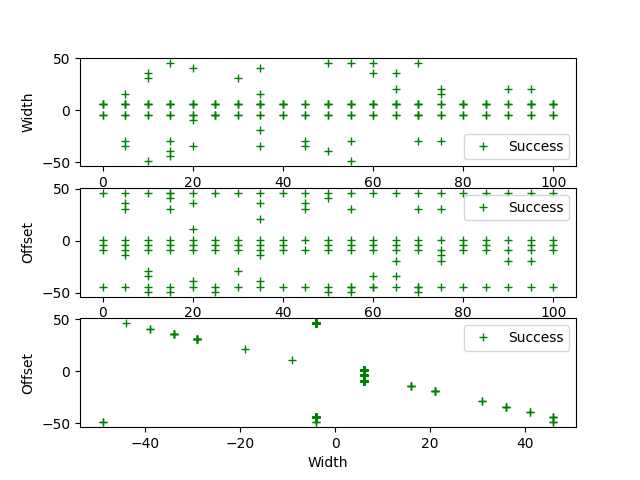

In [23]:
%matplotlib notebook

import matplotlib.pylab as plt
plt.figure()

plt.subplot(3, 1, 1)
experiment.gc.results.plot_2d(plotdots={"success":"+g", "reset":"xr", "normal":None})
plt.subplot(3, 1, 2)
experiment.gc.results.plot_2d(plotdots={"success":"+g", "reset":"xr", "normal":None}, x_index=0, y_index=2)

plt.subplot(3, 1, 3)
experiment.gc.results.plot_2d(plotdots={"success":"+g", "reset":"xr", "normal":None}, x_index=1, y_index=2)

plt.show()

In [18]:
experiment.results

[(<Result.GLITCH: 3>,
  {'r0': 232,
   'r1': 1,
   'r2': 2,
   'r3': 2,
   'r4': 4,
   'r5': 5,
   'r6': 6,
   'r7': 7,
   'r8': 8,
   'r9': 9,
   'r10': 10,
   'r11': 11,
   'r12': 12,
   'r13': 13,
   'r14': 14,
   'r15': 15,
   'r16': 16,
   'r17': 17,
   'r18': 18,
   'r19': 19,
   'r20': 20,
   'r21': 21,
   'r22': 22,
   'r23': 23,
   'r24': 24,
   'r25': 25,
   'r26': 26,
   'r27': 27,
   'r28': 28,
   'r29': 29,
   'r30': 30,
   'r31': 31},
  0,
  -4,
  -44),
 (<Result.GLITCH: 3>,
  {'r0': 232,
   'r1': 1,
   'r2': 2,
   'r3': 0,
   'r4': 4,
   'r5': 5,
   'r6': 6,
   'r7': 7,
   'r8': 8,
   'r9': 9,
   'r10': 10,
   'r11': 11,
   'r12': 12,
   'r13': 13,
   'r14': 14,
   'r15': 15,
   'r16': 16,
   'r17': 17,
   'r18': 18,
   'r19': 19,
   'r20': 20,
   'r21': 21,
   'r22': 22,
   'r23': 23,
   'r24': 24,
   'r25': 25,
   'r26': 26,
   'r27': 27,
   'r28': 28,
   'r29': 29,
   'r30': 30,
   'r31': 31},
  0,
  -4,
  46),
 (<Result.GLITCH: 3>,
  {'r0': 232,
   'r1': 1,
   'r2': 

In [ ]:
# https://gist.github.com/paulochf/f6c9ed0b39f85dd85270

display.display(display.HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

In [ ]:
experiment.scope.dis()
experiment.target.dis()

In [ ]:
def get_dataframe(data):
    df = pd.DataFrame.from_records(data, columns=['result', 'offset', 'width', 'ext_offset', 'data', 'registers'])
    # https://stackoverflow.com/questions/42516616/sort-dataframe-by-string-length
    df['length'] = df['data'].str.len()  # add the count of bytes received

    return df

def display_progress(data):
    df = get_dataframe(data)
    display.display(df.groupby(['data', 'length'])['ext_offset'].describe().sort_values('count'))
    

In [ ]:
tries = []

width_range = Range(-45, 45, 0.4)
offset_range = Range(-45, 45, 0.4)
ext_range = Range(5000, 15000, 0.1)

for _ in range(100000):
    values = list(glitch(offset_range, width_range, ext_range))
    values.insert(0, check(values[-1]))

    tries.append(values)

    if (len(tries) + 1) % 1000 == 0:
        display.clear_output(wait=True)
        display_progress(tries)

## Save the data

Since we generate a lot of data maybe would be wise to save it for later dissection

In [ ]:
def pack_line(line):
    state = struct.pack('B', line[0].value)
    offset = struct.pack('d', line[1])
    width = struct.pack('d', line[2])
    ext_offset = struct.pack('d', line[3])
    len_message = struct.pack('B', len(line[4]))
    
    return b''.join([state, offset, width, ext_offset, len_message, line[4]])

def save_tries(results):
    import datetime
    now = datetime.datetime.now().date().isoformat()
    with open(f'glitching-cw303-{now}.bin', 'wb') as f:
        for _ in tries:
            f.write(pack_line(_))

In [ ]:
save_tries(tries)

## Capture a trace

In [ ]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import CrosshairTool

In [ ]:
# scope.arm()
scope.adc.samples = 3000
scope.clock.adc_src = 'clkgen_x4'
scope.glitch.ext_offset = 9547
scope.glitch.offset = 21
scope.glitch.width = -43
scope.adc.decimate = 1
scope.adc.presamples = 1000

# scope.adc.timeout = 10
scope.adc.offset = scope.glitch.ext_offset
# ret = scope.capture()

print(f'{scope.glitch.ext_offset=} {scope.glitch.width=}')

glitch_on(scope)
trace, msg = capture(with_trace=True)

print(msg)


glitch_off(scope)

output_notebook()
p = figure(sizing_mode='stretch_both', plot_height=400)
x_range = range(0, len(trace))
p.line(x_range, trace)
show(p)

## Pandas

I'll try to analyze a little the data

In [ ]:
%%python3 -m pip install --user pandas

In [ ]:
df = pd.DataFrame.from_records(tries, columns=['result', 'offset', 'width', 'ext_offset', 'data', 'registers'])

Since the only things from which we can understand the behaviour are the messages from the device, I'll try to catalog them

In [ ]:
# https://stackoverflow.com/questions/42516616/sort-dataframe-by-string-length
df['length'] = df['data'].str.len()  # add the count of bytes received

In [ ]:
df.groupby(['data', 'length'])['ext_offset'].describe().sort_values('length').head(50)

In [ ]:
df[df.data == b'\x00hello\x80\x01']
df[df.offset.le(2.8) & df.offset.ge(2.7)].head(1)


we'll try to find where to glitch

In [ ]:
def get_interesting_results(df):
    return df.loc[df.data.str.startswith(b'\x00hello') & ~df.data.str.startswith(b'\x00hello\x80')]

def interesting_stats(df):
    return get_interesting_results(df).groupby(['data', 'length'])['ext_offset'].describe()

def estimate_interval(df):
    stats = interesting_stats(df)
    return stats['min'].min(), stats['max'].max()

interesting = get_interesting_results(df)

stats = interesting_stats(df)

display.display(stats)

offset_min, offset_max = estimate_interval(df)

print(f'we are going to use the interval {offset_min}, {offset_max}')

In [ ]:
df['data'].value_counts()

## Analysis

It seems that around 9547 we obtained the thing that resembles the most a glitch

```
[[<Result.RESET: 2>,
  21.01109202992602,
  -43.195183661139545,
  9547.433869506192,
  b'\x00hello\x80\x16\x8b\xeb\x0b\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\x0c\r\x0e\x0f\x10\x11\x12\x13\x14\x15\x16\x17\x18\x19\x1a\x1b\x1c\x1d\x1e\x1f',
  {}],
```

what seems strange is that the number of cycles seems off with respect to the number of instructions, but if we take into account the way serial communications work then all makes (hopefully) sense: the target uses a baud rate of 38400 baud, this means the in one second can send 38400 bits or 4800 bytes.

Since the way in which is implemented

```c
void output_ch_0(char data)
{
	while(!USART_IsTXDataRegisterEmpty(&USART));
	USART_PutChar(&USART, data);
	return;
}
```

I suppose that each time it sends one character it must wait the physical time it needs the hardware to bit bang the serial port pins: to send one byte takes

In [ ]:
seconds_for_byte = 1/48e2

seconds and if the target run at speed of 8MHz (as indicated by the value in ``scope.clock.clkgen_freq``) we have each cycle takes

In [ ]:
seconds_for_cycle = 1/8e6

seconds, so at the end each byte takes

In [ ]:
bytes_for_cycle = seconds_for_byte/seconds_for_cycle

In [ ]:
len("hello")* bytes_for_cycle

We should try to do some statistics about offsets that when cause a reset also generate the same message from the device

In [ ]:
needle = b'\x16\x8b\xeb\x0b'
[_ for _ in tries_sorted if needle in _[-2]]

Can be of particular interest that doesn't exist a reset with string ``b'\x00hello\x80'``

In [ ]:
[_ for _ in tries if _[0] == Result.GLITCH]

In [ ]:
def session(ext_offset_min, ext_offset_max):
    global scope
    global target

    tries = []

    width_range = Range(-45, 45, 0.4)
    offset_range = Range(-45, 45, 0.4)
    ext_range = Range(ext_offset_min, ext_offset_max, 0.1)

    try:
        for _ in range(100000):
            values = list(glitch(offset_range, width_range, ext_range))
            values.insert(0, check(values[-1]))

            tries.append(values)

            if (len(tries) + 1) % 1000 == 0:
                display.clear_output(wait=True)
                display_progress(tries)
    except:
        pass

    return tries

results = session(offset_min, offset_max)

In [ ]:
df = get_dataframe(results)
df['data']

In [ ]:
hex(ord('l'))

In [ ]:
bin(0x0e)

In [24]:
scope.dis()
target.dis()